In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

Данный датасет собрал в себя информацию о 1260 пациентов с ишемической болезнью сердца. Набор пациентов проводился в рамках кандидатской диссертации, является обезличенным. В файле Excel два листа , на первом собственно данные по пациента, во второгм "Легенда" расшифровка цифровых значений.

Пациенты идентифицированы: 
по половозрастной структуре, 
краткое клиническое описание (клинические проявления ИБС, информация о перенесенном инфаркте миокарда и его виде), стадии хронической сердечной недостаточности, коморбидной патологии (СД, АГ, перенесенный ОНМК, клинически значимый атеросклероз нижних конечностей)
краткие данные по инструментальным (ЭКГ, ЭхоКГ, ХМ ЭКГ, УЗДГ БЦА, стрессовые пробы) и некоторым лабораторным показателям на момент госпитализации (глюкоза крови, креатинин, липидный спектр).
Всем пациентам выполонена коронарография (детализирована), на основании чего сделан вывод о выраженности поражения коронарных артерий и дальнейшей тактике ведения пациента.
Основная мысль исследования: разработать модель, которая на основании клинических проявлений будет предполагать хирургически значимые стенозы коронарных артерий. Таким образом, возможна стратификация пациентов для выполнения инвазивного исследования и максимизации клинической пользы для популяции с минимизацией усилий системы здравоохранения.

In [2]:
raw_data = pd.read_excel("База итоговая.xlsx", sheet_name = 'Полная база')

In [3]:
df = pd.DataFrame(raw_data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 76 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   №                     1260 non-null   int64         
 1   повтор                1260 non-null   int64         
 2   Раса                  1260 non-null   int64         
 3   год рождения          1260 non-null   int64         
 4   возраст на момент КГ  1260 non-null   int64         
 5   пол                   1260 non-null   int64         
 6   Всего ИМ              792 non-null    float64       
 7   операция              1260 non-null   int64         
 8   Дата последнего ИМ    792 non-null    float64       
 9   Давность ИМ           1259 non-null   float64       
 10  форма ИМ              1260 non-null   int64         
 11  ПИКС                  1260 non-null   int64         
 12   боль                 1260 non-null   int64         
 13  ХСН               

Ряд столбцов не пригодятся: порядковый номер, год рождения (есть возраст на момент включения в исследование), дата КАГ, количество перенесенных инфарктов, дата последнего ИМ. 
Убираем ненужную детализацию: описательная часть КАГ, особенности АГ: ГБ/САГ, редко выполнены: фракции ХС, СДЛА, МДЛА, стресс. 
Из таргетных логично оставить только значимые по максимальным критериям: убираем мягкий критерий, кол-во сосудов, рестеноз, решение.

In [4]:
df.drop(columns = ['№', 'Всего ИМ', 'Дата последнего ИМ' ,'Давность ИМ', 'год рождения', 'Дата КГ', 'СДЛА', 'ГБ/САГ', 'МДЛА', 'Стресс', 'ЛПВП', 'ЛПОНП', 'ЛПНП', 'ИА'], inplace =True)
df.drop(columns = ['Переток', 'Ствол ЛКА', 'ПНА проксим', 'ПНА средн', 'ПНА дист', 'диагнальная', 'пром'], inplace =True)
df.drop(columns = ['септальные', 'ОВ прокс', 'ОВ сред', 'ОВ дист', 'ВТК', 'ПКА прокс','ПКА средняя'], inplace =True)
df.drop(columns = ['ПКА дист', 'ВОК', 'ЛЖ', 'ЗМЖВ', 'тип кровотока', 'кол-во сосудов','рестеноз', 'мягкий критери', 'Решение'], inplace =True)

Итого из 75 осталось 39 переменных, из них одна является таргетной. Логичным является оставить в базе только первичные случаи регистрации. Уберём лишний показатель, осталось 1143 уникальных случая.

In [5]:
df_prepared = df.loc[df['повтор'] == 0].copy()
df_prepared.drop(columns = ['повтор'], inplace =True)
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143 entries, 0 to 1259
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Раса                  1143 non-null   int64  
 1   возраст на момент КГ  1143 non-null   int64  
 2   пол                   1143 non-null   int64  
 3   операция              1143 non-null   int64  
 4   форма ИМ              1143 non-null   int64  
 5   ПИКС                  1143 non-null   int64  
 6    боль                 1143 non-null   int64  
 7   ХСН                   1143 non-null   int64  
 8   э/с клин              1143 non-null   int64  
 9   аневризма             1143 non-null   int64  
 10  почек                 1143 non-null   int64  
 11  периф атз             1143 non-null   int64  
 12  онмк                  1143 non-null   int64  
 13  ако                   1143 non-null   int64  
 14  СД                    1143 non-null   int64  
 15  АГ                   

Поправим названия переменных в более удачные. Исправим граматические и лексические ошибки.

In [6]:
df_prepared.rename(columns = {'возраст на момент КГ':'Возраст',' боль':'Характер ИБС','э/с клин':'ЖЭС','ЖЭ':'ЖЭС по ХМ','ст': 'ST', 'аневризма.1' :'Аневризма ЛЖ'}, inplace = True)

Выявлены проблемы: малый охват Холтеровским мониторированием (ЖЭС, девиация ST, ср ЧСС)
2 показателя идентифицируются как объекты: глюкоза, группа крови. Глюкозу просто убираем нечисловое значение (есть '-' вместо пропуска). Группу крови перекодируем 0 - 1, A (II) - 2, B (III) - 3, AB - 4

In [7]:
df_prepared['глюкоза'] = df_prepared['глюкоза'].map(lambda x: ''.join([i for i in str(x) if i.isdigit()]))
df_prepared['Группа крови'] = df_prepared['Группа крови'].str.replace(r'[^0,A,B,AB]', '') # убрал всё, что не относится к группе крове по системе АВ0. 
df_prepared['Группа крови'] = df_prepared['Группа крови'].str.replace('0', '1')
df_prepared['Группа крови'] = df_prepared['Группа крови'].str.replace('AB', '4')
df_prepared['Группа крови'] = df_prepared['Группа крови'].str.replace('A', '2')
df_prepared['Группа крови'] = df_prepared['Группа крови'].str.replace('B', '3')
df_prepared['Группа крови'] = df_prepared['Группа крови'].str.replace('311', '')  # одна группа крови неправильно закодирована

In [8]:
df_prepared['Группа крови'] = df_prepared['Группа крови'].str.replace(r'[^1-4]', '') # повторил, так как некоторые убрались некорректно

In [9]:
df_prepared.loc[(df_prepared['Группа крови'] == ''), (['Группа крови'])] = np.nan
df_prepared.loc[(df_prepared['глюкоза'] == ''), (['глюкоза'])] = np.nan
df_prepared['глюкоза'].astype(str)
df_prepared['глюкоза'] = df_prepared['глюкоза'].astype(float)
df_prepared['Группа крови'].astype(str) # с первого раза не получается :( почему я не понимаю.
df_prepared['Группа крови'] = df_prepared['Группа крови'].astype(float)
df_prepared['Группа крови'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1143 entries, 0 to 1259
Series name: Группа крови
Non-Null Count  Dtype  
--------------  -----  
958 non-null    float64
dtypes: float64(1)
memory usage: 17.9 KB


In [10]:
df_prepared.isna().sum()

Раса              0
Возраст           0
пол               0
операция          0
форма ИМ          0
ПИКС              0
Характер ИБС      0
ХСН               0
ЖЭС               0
аневризма         0
почек             0
периф атз         0
онмк              0
ако               0
СД                0
АГ                0
ритм              0
Ишемия            0
ветви ЛПНПГ       0
ПБПНПГ            0
ПБЛПНГ            0
гипокинез       136
Аневризма ЛЖ    136
рубц изм        136
КДР ЛЖ          186
ФВ              171
ЖЭС по ХМ       462
ST              462
ср чсс          512
каротиды        507
Hb              120
СОЭ             131
глюкоза         145
Креатинин       233
СКФ             233
ОХС             233
Группа крови    185
Значимые          0
dtype: int64

Таким образом, у ряда признаков нет полного охвата:
по УЗДГ БЦА: нет 507 из 1143, 
по ХМ ЭКГ: пропущено 462 из 1143 значений
ЭхоКГ:171-136 из 1143 значений , 
общеклинические анализы  120-145 из 1143 значений.
Принципиально в данном датасете наличие показателей ЭхоКГ. УЗДГ БЦА очень важно и учитывая объём не может быть восполнен, поэтому логичнее для него создать новый датасет для дальнейшего анализа.

Прочие же показатели можно проставить по среднему.

In [11]:
df_full = df_prepared.loc[df_prepared['ФВ'].notnull()]
df_full = df_full.loc[df_full['каротиды'].notnull()]

Мы можем убрать КДР ЛЖ, поскольку имеем её производную: фракцию выброса (ФВ).
Убираем креатинин, так как имеем более ценную её производную: скорость клубочковой фильтрации(СКФ)

In [12]:
df_full.drop(columns = ['КДР ЛЖ', 'Креатинин'], inplace =True)

Признаки 'ЖЭС по ХМ', девиация ST, группа крови - категориальные. 
Прочие недостающие данные заменяем средними значениями. Поскольку действия повторяющееся вводим функции filling_random и filling_empty.
Для категориальных попробуем сделать замену соотвественно распределению значений в остальном массиве значений.

In [13]:
from random import choices

def filling_random(column):
    distr_dict = dict(df_full[column].value_counts())
    def random_result():
        return choices(list(distr_dict.keys()), weights=list(distr_dict.values()))
    def flatten(l):
        return [item for sublist in l for item in sublist]
    insert = flatten([random_result() for _ in range(1259)]) # я понял что нужно так, поскольку исходных индексов было 1259
    df_full[column] = df_full[column].fillna(pd.Series(insert))

In [14]:
filling_random('ЖЭС по ХМ')
filling_random('ST')
filling_random('Группа крови')

In [15]:
def filling_empty(column):
    df_full[column] = df_full[column].fillna(df_full[column].mean())

In [16]:
filling_empty('ср чсс')
filling_empty('Hb')
filling_empty('СОЭ')
filling_empty('глюкоза')
filling_empty('СКФ')
filling_empty('ОХС')

In [17]:
df_full.isna().sum()

Раса            0
Возраст         0
пол             0
операция        0
форма ИМ        0
ПИКС            0
Характер ИБС    0
ХСН             0
ЖЭС             0
аневризма       0
почек           0
периф атз       0
онмк            0
ако             0
СД              0
АГ              0
ритм            0
Ишемия          0
ветви ЛПНПГ     0
ПБПНПГ          0
ПБЛПНГ          0
гипокинез       0
Аневризма ЛЖ    0
рубц изм        0
ФВ              0
ЖЭС по ХМ       0
ST              0
ср чсс          0
каротиды        0
Hb              0
СОЭ             0
глюкоза         0
СКФ             0
ОХС             0
Группа крови    0
Значимые        0
dtype: int64

In [18]:
df_full.describe()

,Раса,Возраст,пол,операция,форма ИМ,ПИКС,Характер ИБС,ХСН,ЖЭС,аневризма,...,ST,ср чсс,каротиды,Hb,СОЭ,глюкоза,СКФ,ОХС,Группа крови,Значимые
count,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,...,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000
mean,1.033217,54.533217,1.236014,0.129371,1.155594,0.643357,2.673077,2.776224,0.762238,0.078671,...,0.159091,72.378082,0.122378,152.339575,10.849903,145.290766,78.740929,5.017812,2.036713,1.349650
std,0.179359,7.905347,0.425003,0.389050,0.933097,0.479427,1.130585,0.524958,1.500534,0.269461,...,0.366081,8.436829,0.333305,13.874903,7.728701,187.003381,18.970788,1.057655,0.935980,0.873897
min,1.000000,26.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,46.000000,0.000000,109.000000,1.000000,3.000000,35.837268,2.170000,1.000000,0.000000
25%,1.000000,49.000000,1.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,...,0.000000,69.000000,0.000000,145.000000,5.000000,45.000000,67.756826,4.400000,1.000000,0.000000
50%,1.000000,54.000000,1.000000,0.000000,1.000000,1.000000,3.000000,3.000000,0.000000,0.000000,...,0.000000,72.378082,0.000000,152.339575,10.000000,55.000000,78.740929,5.017812,2.000000,2.000000
75%,1.000000,59.000000,1.000000,0.000000,2.000000,1.000000,3.000000,3.000000,0.000000,0.000000,...,0.000000,75.000000,0.000000,161.000000,14.000000,145.290766,85.347690,5.500000,3.000000,2.000000
max,2.000000,80.000000,2.000000,2.000000,3.000000,1.000000,5.000000,5.000000,6.000000,1.000000,...,1.000000,120.000000,2.000000,193.000000,47.000000,1224.000000,195.810483,11.000000,4.000000,2.000000


Таким образом, у нас получился датасет из 572 наблюдений.

Категориальные показатели: раса, пол, операция в анамнезе, форма перенесенного инфаркта миокарда, наличие/отсутствие ИМ в анамнезе, клиническое течение ИБС,  стадия хронической сердечной недостаточности, желудочковая экстрасистолия, аневризма, поражение сонных артерии, группа крови по системе АВ0
- Группу крови разнесём на разные фичи, т.к. она не имеют характера интенсивности
- Клиническое течение ИБС, стадия хронической сердечной недостаточности, желудочковая экстрасистолия - ранговые показатели, чем более тем хуже.
- Ритм из клинических соображения можно упростить: на нормальный (синусовый) и патологический
- Детализированные изменения по ЭКГ можно упростить все блокады соединим в одну.

In [19]:
df_full = pd.concat([df_full, pd.get_dummies(df_full['Группа крови'])], axis=1)
df_full.rename(columns={1.0:'O(I)', 2.0:'A(II)', 3.0:'B(III)', 4.0:'C(IV)'}, inplace=True)
df_full.drop(columns = 'Группа крови', inplace =True)
df_full.columns

Index(['Раса', 'Возраст', 'пол', 'операция', 'форма ИМ', 'ПИКС',
       'Характер ИБС', 'ХСН', 'ЖЭС', 'аневризма', 'почек', 'периф атз', 'онмк',
       'ако', 'СД', 'АГ', 'ритм', 'Ишемия', 'ветви ЛПНПГ', 'ПБПНПГ', 'ПБЛПНГ',
       'гипокинез', 'Аневризма ЛЖ', 'рубц изм', 'ФВ', 'ЖЭС по ХМ', 'ST',
       'ср чсс', 'каротиды', 'Hb', 'СОЭ', 'глюкоза', 'СКФ', 'ОХС', 'Значимые',
       'O(I)', 'A(II)', 'B(III)', 'C(IV)'],
      dtype='object')

In [20]:
df_full.insert(19,'Блокада по ЭКГ', 0)
df_full.columns

Index(['Раса', 'Возраст', 'пол', 'операция', 'форма ИМ', 'ПИКС',
       'Характер ИБС', 'ХСН', 'ЖЭС', 'аневризма', 'почек', 'периф атз', 'онмк',
       'ако', 'СД', 'АГ', 'ритм', 'Ишемия', 'ветви ЛПНПГ', 'Блокада по ЭКГ',
       'ПБПНПГ', 'ПБЛПНГ', 'гипокинез', 'Аневризма ЛЖ', 'рубц изм', 'ФВ',
       'ЖЭС по ХМ', 'ST', 'ср чсс', 'каротиды', 'Hb', 'СОЭ', 'глюкоза', 'СКФ',
       'ОХС', 'Значимые', 'O(I)', 'A(II)', 'B(III)', 'C(IV)'],
      dtype='object')

In [21]:
df_full.loc[(((df_full['ветви ЛПНПГ'] == 1.0) | (df_full['ПБПНПГ'] == 1.0) | (df_full['ПБЛПНГ'] == 1.0)), (['Блокада по ЭКГ']))] = 1

In [22]:
df_full['Блокада по ЭКГ'].value_counts()

0    524
1     48
Name: Блокада по ЭКГ, dtype: int64

In [23]:
df_full.drop(columns = ['ветви ЛПНПГ', 'ПБПНПГ', 'ПБЛПНГ'], inplace =True)

In [24]:
df_full['ритм'] = df_full['ритм'].replace(3.0, 2)
df_full['ритм'] = df_full['ритм'].replace(4.0, 2)

Количественные показатели: возраст, средняя частота по данным холтеровского мониторирования, гемоглобин, скорость оседания эритроцитов, креатинин, скорость клубочковой фильтрации, общий холестерин.
Таргетная величина категориальная: поражение коронарных артерий отсутствует, клинически незначимо, требует оперативного лечения. Для простоты и практической ценности можно упростить таргетную величину: не требует/требует оперативного лечения. Итого получаем сравнимые исходы: 219 пациентов не требует хирургии, 353 требуют.

In [25]:
df_full['Значимые'] = df_full['Значимые'].replace(0, 1)
df_full['Значимые'].value_counts()

2    353
1    219
Name: Значимые, dtype: int64

Логично проверить, что во всех категориальных показателях у нас правильное количество вариантов значения (лишние не выводим).

In [26]:
[f'Для признака "{col}" - вариантов {len(df_full[col].value_counts())}' for col in ['Раса', 'пол', 'операция', 'форма ИМ', 
       'Характер ИБС', 'ХСН', 'ЖЭС', 'аневризма', 'почек', 'периф атз', 'онмк',
       'ако', 'СД', 'АГ', 'ритм', 'Ишемия', 'Блокада по ЭКГ',
       'гипокинез', 'Аневризма ЛЖ', 'рубц изм', 'ЖЭС по ХМ', 'ST',
       'каротиды','O(I)', 'A(II)', 'B(III)', 'C(IV)'
       , 'Значимые'] if len(df_full[col].value_counts()) > 2]

['Для признака "операция" - вариантов 3',
 'Для признака "форма ИМ" - вариантов 4',
 'Для признака "Характер ИБС" - вариантов 6',
 'Для признака "ХСН" - вариантов 5',
 'Для признака "ЖЭС" - вариантов 7',
 'Для признака "АГ" - вариантов 5',
 'Для признака "ЖЭС по ХМ" - вариантов 7',
 'Для признака "каротиды" - вариантов 3']

Найдена ошибка: в каротидах 3 варианта, хотя бинарный признак. 


In [27]:
df_full['каротиды'].value_counts() # одно значение 2 скорее всего было закодировано наличие - опечатка

0.0    503
1.0     68
2.0      1
Name: каротиды, dtype: int64

In [28]:
df_full['каротиды'] = df_full['каротиды'].replace(2, 1)

Посмотрим корреляцию категориальных признаков

<AxesSubplot:>

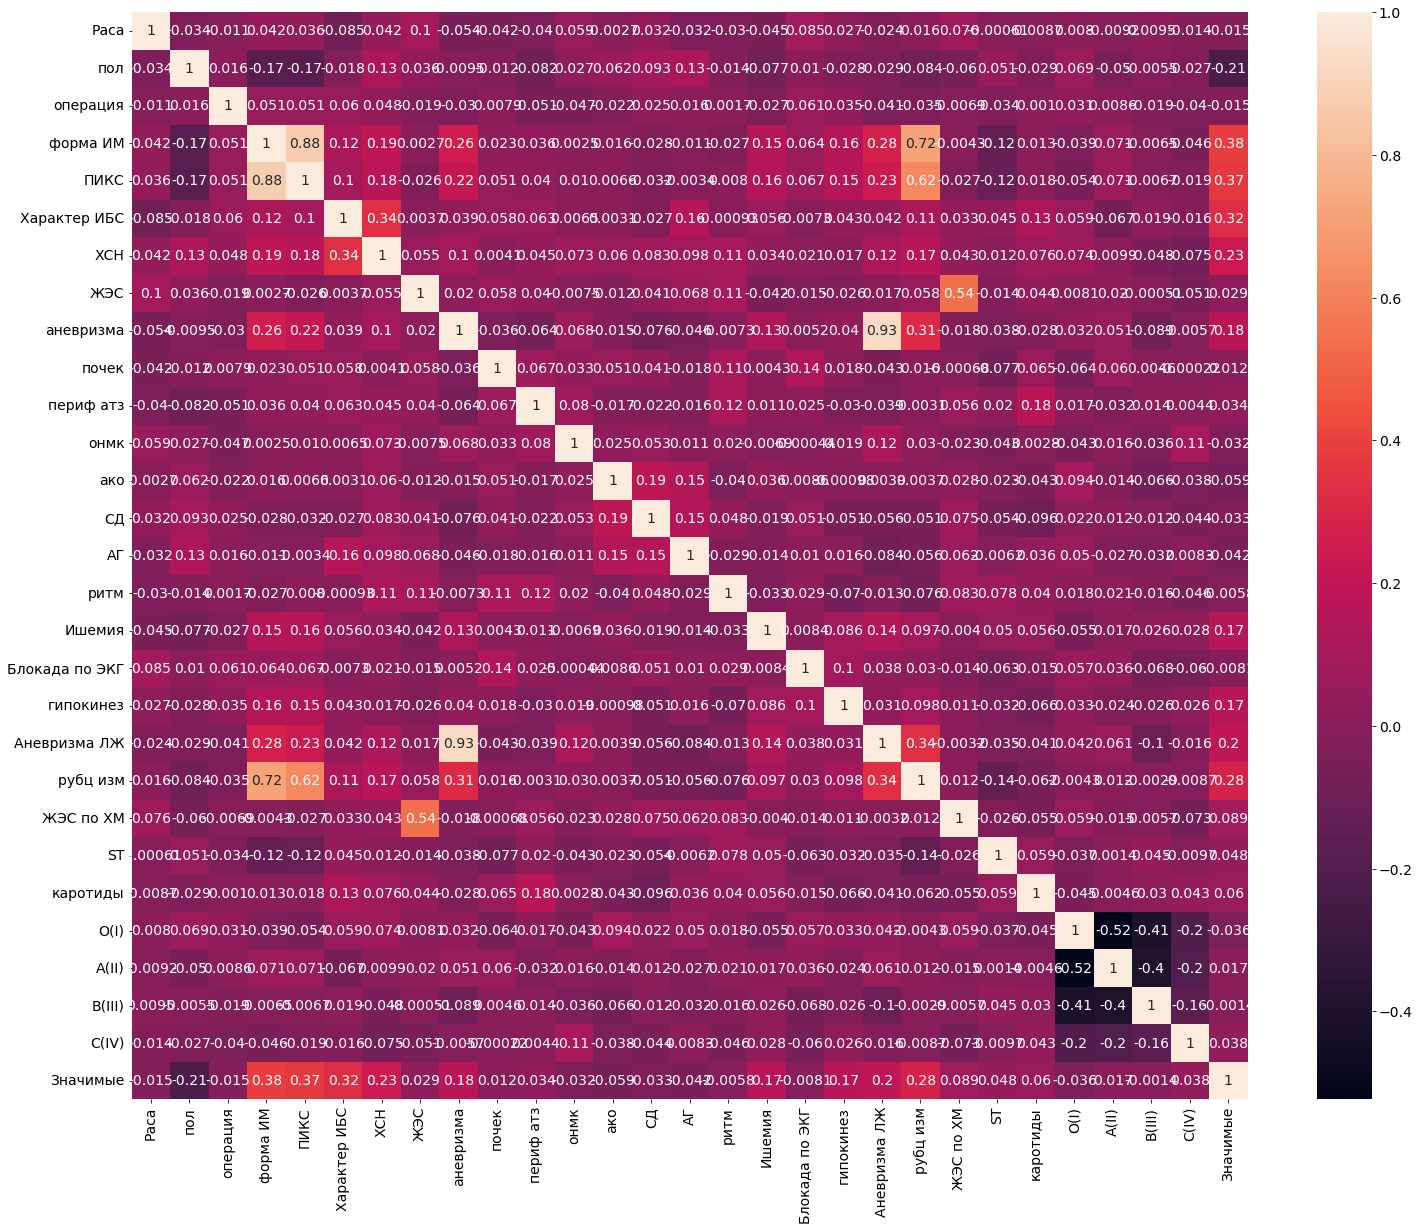

In [29]:
df_cat = df_full[['Раса', 'пол', 'операция', 'форма ИМ', 'ПИКС',
       'Характер ИБС', 'ХСН', 'ЖЭС', 'аневризма', 'почек', 'периф атз', 'онмк',
       'ако', 'СД', 'АГ', 'ритм', 'Ишемия', 'Блокада по ЭКГ',
       'гипокинез', 'Аневризма ЛЖ', 'рубц изм', 'ЖЭС по ХМ', 'ST',
       'каротиды','O(I)', 'A(II)', 'B(III)', 'C(IV)'
       , 'Значимые']].copy()
plt.figure(figsize = (25,20))
sns.heatmap(df_cat.corr(), annot=True)

Относительная высокая корреляция отмечается в парах ХСН - характер ИБС, аневризм - форма ИМ,  рубцовые изменения и форма ИМ
Это объясняется и клинически: пациент с крупноочаговым ИМ, и ИМ, как таковым, чаще получит осложнение в виде постинфарктной аневризмы.
Логичным представляется оставить только переменную Форма ИМ в ИМ с Q, без Q и без ИМ в анамнезе. По сути ПИКС просто упрощал эти данные. Убираем рубцовые изменения по ЭКГ, так как при их наличии обязательно форма ИМ установливалась, как крупноочаговый в анамнезе. Убираем аневризму по анамнезу, оставим только по данных ЭхоКГ. Уберём ЖЭС указанное в диагнозе, оставим на ЖЭС по ХМ ЭКГ
По паре же ХСН - характер ИБС ситуация другая: человек с выраженной клинической картиной зачастую имеет больший анамнез ИБС и с большей вероятностью приобретёт тяжёлую ХСН, но объединять эти параметры представляется нелогичным, так как клинические проявления разные (при тяжёлой коронарной недостаточности может не быть отёков, а при тяжёлой ХСН не быть болевого синдрома).
Исключаем из матрицы корреляции группы крови.

In [30]:
df_full.drop(columns = ['ПИКС', 'рубц изм', 'аневризма', 'ЖЭС'], inplace =True)


<AxesSubplot:>

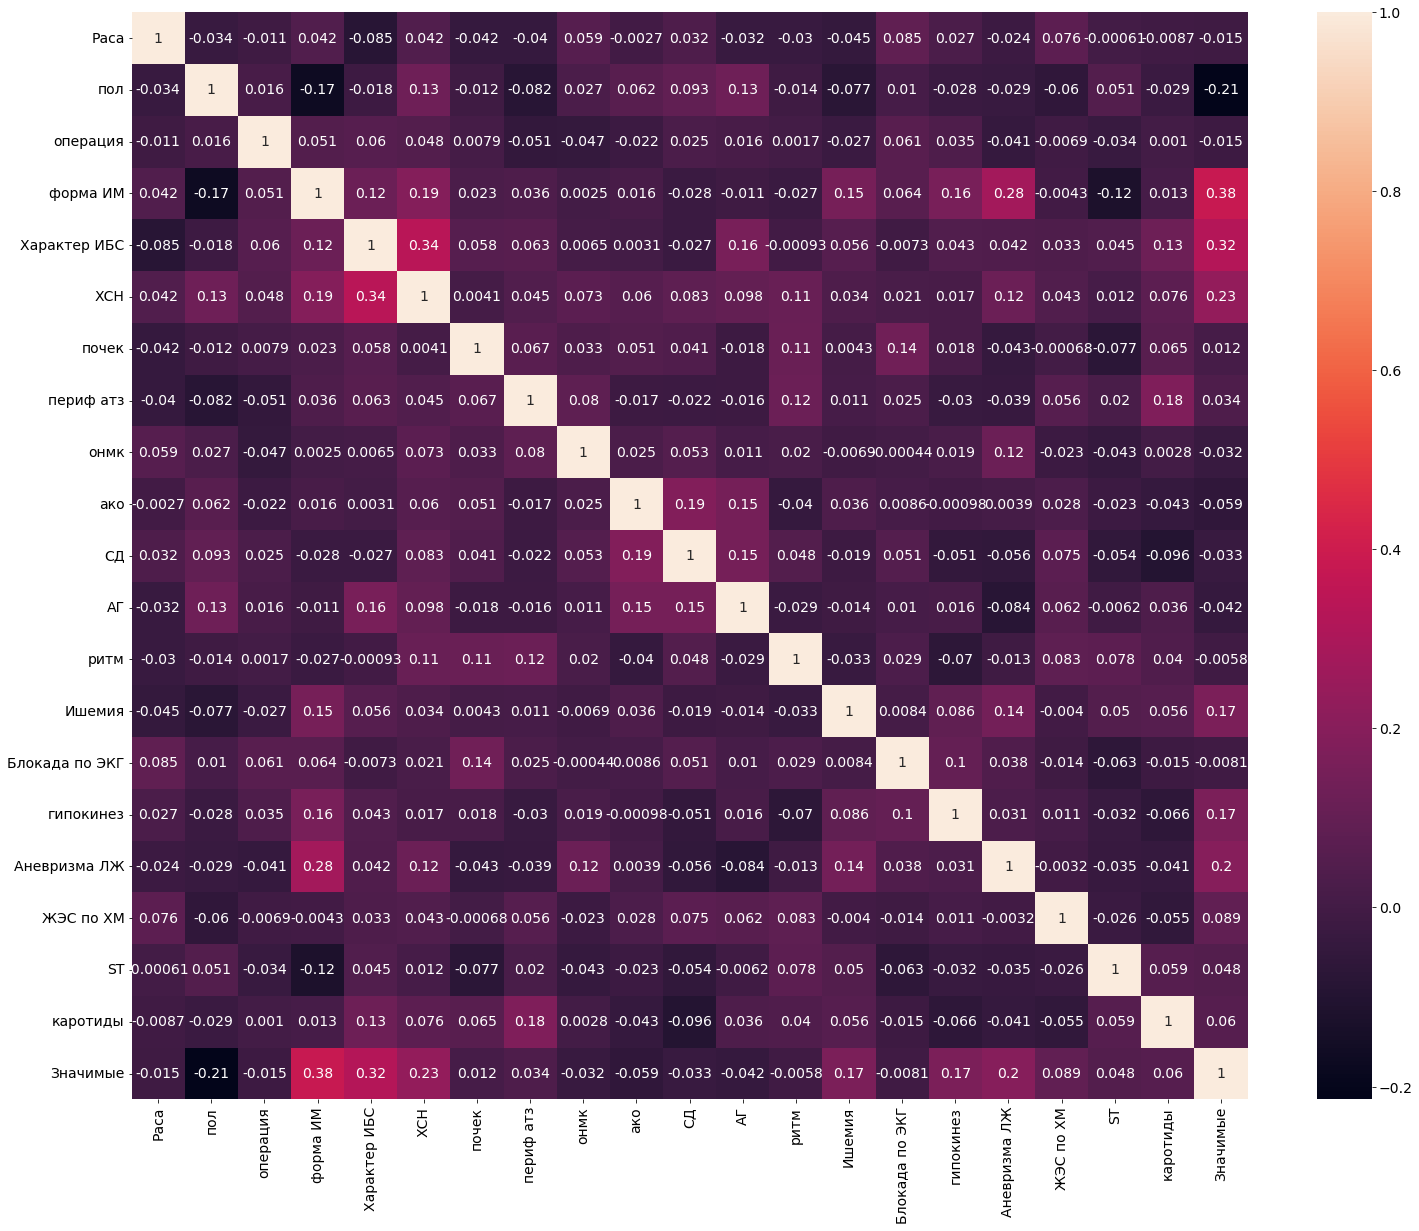

In [31]:
df_cat = df_full[['Раса', 'пол', 'операция', 'форма ИМ',
       'Характер ИБС', 'ХСН', 'почек', 'периф атз', 'онмк',
       'ако', 'СД', 'АГ', 'ритм', 'Ишемия', 'Блокада по ЭКГ',
       'гипокинез', 'Аневризма ЛЖ', 'ЖЭС по ХМ', 'ST',
       'каротиды','Значимые']].copy()
plt.figure(figsize = (25, 20))
sns.heatmap(df_cat.corr(), annot=True)

<AxesSubplot:xlabel='Значимые', ylabel='Возраст'>

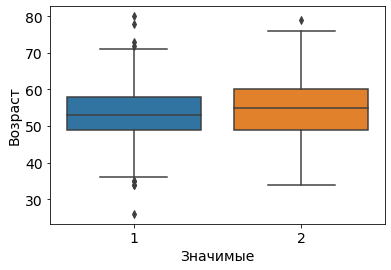

In [32]:
sns.boxplot(data=df_full, x=df_full['Значимые'], y=df_full['Возраст'])

<AxesSubplot:xlabel='Значимые', ylabel='ср чсс'>

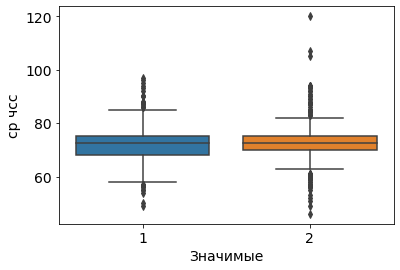

In [33]:
sns.boxplot(data=df_full, x=df_full['Значимые'], y=df_full['ср чсс'])

<AxesSubplot:xlabel='Значимые', ylabel='Hb'>

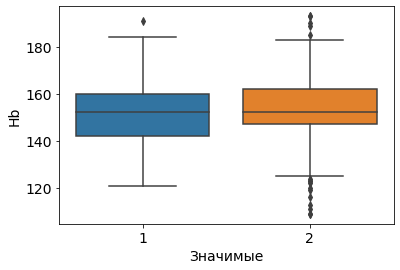

In [34]:
sns.boxplot(data=df_full, x=df_full['Значимые'], y=df_full['Hb'])

<AxesSubplot:xlabel='Значимые', ylabel='СОЭ'>

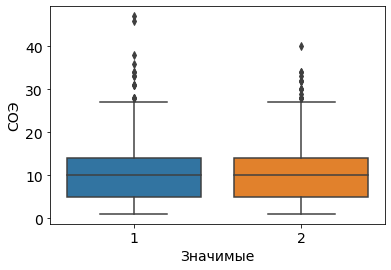

In [35]:
sns.boxplot(data=df_full, x=df_full['Значимые'], y=df_full['СОЭ'])

<AxesSubplot:xlabel='Значимые', ylabel='СКФ'>

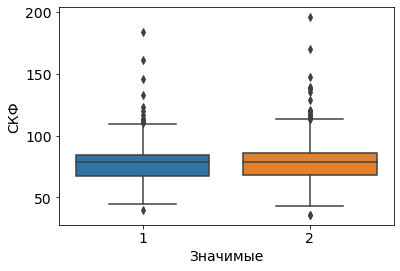

In [36]:
sns.boxplot(data=df_full, x=df_full['Значимые'], y=df_full['СКФ'])

<AxesSubplot:xlabel='Значимые', ylabel='глюкоза'>

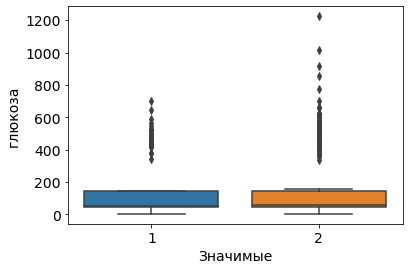

In [37]:
sns.boxplot(data=df_full, x=df_full['Значимые'], y=df_full['глюкоза'])

<AxesSubplot:xlabel='Значимые', ylabel='ОХС'>

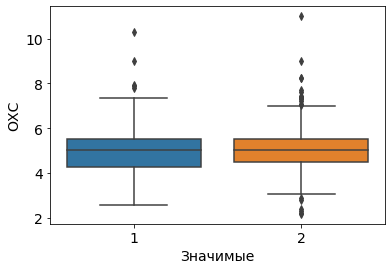

In [38]:
sns.boxplot(data=df_full, x=df_full['Значимые'], y=df_full['ОХС'])

В вышеуказанных графиках мы видим, что значимого различия не отмечается. 
Таким образом итоговый датафрейм состоит из 572 случаев. Признаков 32, из них количественных 7

Проводим стандартизацию количественных показателей

In [39]:
df_full[['Возраст', 'ср чсс','Hb', 'СОЭ', 'СКФ', 'глюкоза','ОХС']]

,Возраст,ср чсс,Hb,СОЭ,СКФ,глюкоза,ОХС
0,51,69.000000,152.339575,10.849903,68.811484,96.000000,4.600000
1,52,72.378082,136.000000,25.000000,61.481526,47.000000,6.600000
2,49,78.000000,136.000000,8.000000,53.168570,51.000000,4.500000
3,52,79.000000,167.000000,12.000000,75.926922,474.000000,3.400000
5,46,72.378082,161.000000,2.000000,77.840324,48.000000,4.700000
...,...,...,...,...,...,...,...
1250,46,72.378082,152.339575,10.849903,78.740929,145.290766,5.017812
1252,59,83.000000,140.000000,5.000000,99.622265,93.000000,5.300000
1255,37,65.000000,146.000000,2.000000,100.409472,38.000000,4.430000
1256,64,63.000000,124.000000,14.000000,71.081413,57.000000,5.017812


In [40]:
feature_names = ['Возраст', 'ср чсс','Hb', 'СОЭ',  'глюкоза', 'СКФ','ОХС']
feature_names_for_stand = df_full[feature_names].columns.tolist()

In [41]:
df_full.columns

Index(['Раса', 'Возраст', 'пол', 'операция', 'форма ИМ', 'Характер ИБС', 'ХСН',
       'почек', 'периф атз', 'онмк', 'ако', 'СД', 'АГ', 'ритм', 'Ишемия',
       'Блокада по ЭКГ', 'гипокинез', 'Аневризма ЛЖ', 'ФВ', 'ЖЭС по ХМ', 'ST',
       'ср чсс', 'каротиды', 'Hb', 'СОЭ', 'глюкоза', 'СКФ', 'ОХС', 'Значимые',
       'O(I)', 'A(II)', 'B(III)', 'C(IV)'],
      dtype='object')

В следующей ячейке я попытался масштабировать количественные показатели.
Не могу почему это происходит, однако записывается 330 Nan, что бы я не делал.

In [42]:
#scaler = RobustScaler()
#insertion = pd.DataFrame(scaler.fit_transform(df_full[feature_names_for_stand]), columns=feature_names_for_stand)
#df_full.drop(columns =['Возраст', 'ср чсс','Hb', 'СОЭ','глюкоза','СКФ','ОХС'], inplace =True)
#df_result = pd.concat([df_full,insertion], axis = 1)

In [43]:
X = df_full[['Раса', 'пол', 'операция', 'форма ИМ', 'Характер ИБС', 'ХСН',
       'почек', 'периф атз', 'онмк', 'ако', 'СД', 'АГ', 'ритм', 'Ишемия',
       'Блокада по ЭКГ', 'гипокинез', 'Аневризма ЛЖ', 'ФВ', 'ЖЭС по ХМ', 'ST',
        'каротиды', 'Значимые',
       'O(I)', 'A(II)', 'B(III)', 'C(IV)']]
Y = df_full['Значимые']

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=42)

In [45]:
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)

LogisticRegression()

Правильно я понял, что тестовой выборке 100 процентное предсказание???

In [46]:
prediction = logreg.predict(X_test)

print(classification_report(Y_test,prediction))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00       105

    accuracy                           1.00       189
   macro avg       1.00      1.00      1.00       189
weighted avg       1.00      1.00      1.00       189

